# Alternating Descent Conditional Gradient

1D Deconvolution using ADCG.

## Imports

In [23]:
import autograd.numpy as np
import autograd
import scipy.optimize
import pylab
from time import time
import seaborn as sns
pylab.ion()

## Style

In [24]:
sns.set_style("darkgrid")
pylab.rcParams["lines.linestyle"] = ':'
pylab.rcParams["lines.linewidth"] = 5
pylab.rcParams["figure.figsize"] = (14, 3)

## Global variables

In [25]:
# Global variables
evaluation_points = np.linspace(0, 1, 50)
σ = 0.1

## Gaussian plot example

In [26]:
# Gaussian
def ψ(θ):
    return np.exp(-((evaluation_points - θ) / σ) ** 2)

In [27]:
ψ(0.3).shape

(50,)

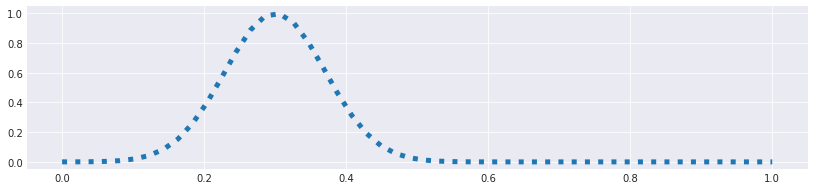

In [28]:
pylab.plot(evaluation_points, ψ(0.3));

## Utility functions

In [29]:
# Weighted shifted gaussian functions
def Ψ(ws, θs):
    return np.sum(np.array([w*ψ(θ) for (w, θ) in zip(ws, θs)]), 0)

In [30]:
# Loss function
def l(ws, θs):
    return ((Ψ(ws, θs) - y) ** 2).sum()

## Problem setting

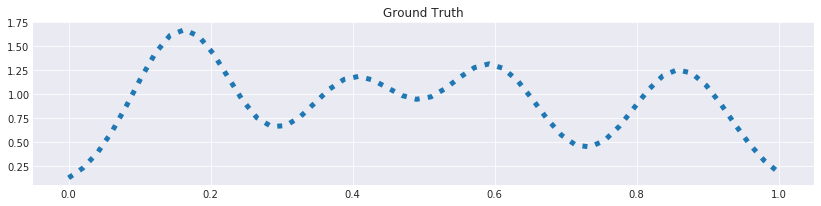

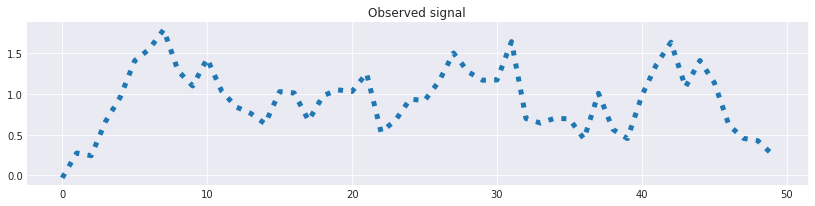

In [31]:
# Generate ground truth θs and weights ws
np.random.seed(69)
num_true_θs = np.random.randint(2, 5)
noise_level = 0.2
true_θs = np.random.rand(num_true_θs)
true_weights = np.random.rand(num_true_θs) + 1
y = (Ψ(true_weights, true_θs) 
     + noise_level * np.random.randn(len(evaluation_points)))
pylab.figure()
pylab.title("Ground Truth")
pylab.plot(evaluation_points, Ψ(true_weights, true_θs))
pylab.figure()
pylab.title("Observed signal")
pylab.plot(y);

In [32]:
# ADCG first step "linear minimization oracle"
# We will grid θ to approximately solve the problem
grid_points = np.linspace(0, 1, 30)
grid_psi = np.stack([ψ(θ) for θ in grid_points])

## Resolution methods

In [33]:
def lmo(v):
    scores = grid_psi @ v
    return grid_points[scores.argmin()]

In [34]:
# ADCG second step "coordination optimization solving attempt"
def coordinate_descent(θs, iters=35, min_drop=1e-5):
    def min_ws():
        return scipy.optimize.nnls(np.stack([ψ(θ) for θ in θs]).T, y)[0]
    def min_θs():
        res = scipy.optimize.minimize(
                autograd.value_and_grad(lambda θs: l(ws, θs)),
                                        θs,
                                        jac=True,
                                        method='L-BFGS-B',
                                        bounds=[(0.0, 1.0)]*len(θs))
        return res["x"], res["fun"]
    
    old_f_val = np.inf
    for iter in range(iters):
        ws = min_ws()
        θs, f_val = min_θs()
        # check if loss is stationary
        if old_f_val - f_val < min_drop:
            break
        old_f_val = f_val
    return ws, θs

In [35]:
# ADCG second step "joint optimization solving attempt"
def local_search(θs):
    n = len(θs)
    # Stack weights and θs into a vector
    def f(x):
        return l(x[:n], x[n:])
    x_init = np.concatenate((np.zeros(n), θs))
    res = scipy.optimize.minimize(
            autograd.value_and_grad(f),
            x_init,
            jac=True,
            method="L-BFGS-B",
            bounds=([(0.0, None)]*n) + ([(0.0, 1.0)]*n))
    x = res["x"]
    ws = x[:n]
    θs = x[n:]
    return ws, θs

In [36]:
# Define ADCG
def ADCG(local_update, max_iters):
    θs = np.zeros(0)
    ws = np.zeros(0)
    output = np.zeros(len(evaluation_points))
    history = list()
    for iter in range(max_iters):
        residual = output - y
        loss = (residual**2).sum()
        #print(iter, loss)
        history.append((loss, θs, ws))
        θ = lmo(residual)
        ws, θs = local_update(np.append(θs, θ))
        output = Ψ(ws, θs)
    return history

In [37]:
# Define heuristic for selecting the number of true sources
def select_k(history):
    drop = np.array([history[i][0] - history[i+1][0]
                    for i in range(len(history) - 1)])
    k_hat = np.argmax(drop<0.1)
    return history[k_hat]

Ground truth results
---------------------
True loss: 2.608359358459474
True θs: [0.40157872 0.59582391 0.16174899 0.8603238 ]
True weights: [1.1430533  1.28132229 1.66428121 1.25002847]
---------------------

Coordinate descent results
---------------------
Coordinate descent loss: 2.074
Coordinate descent θs: [0.15096487 0.59086732 0.86430903 0.37707529]
Coordinate descent weights: [1.55972496 1.41077923 1.36876526 1.04324896]
Coordinate descent timing: 1.302s
---------------------

Joint optimization results
---------------------
Local search loss: 2.074
Local search θs: [0.15096361 0.59086983 0.86430868 0.37707719]
Local search weights: [1.55972826 1.41072462 1.36871783 1.04334755]
Local search timing: 2.078s
---------------------



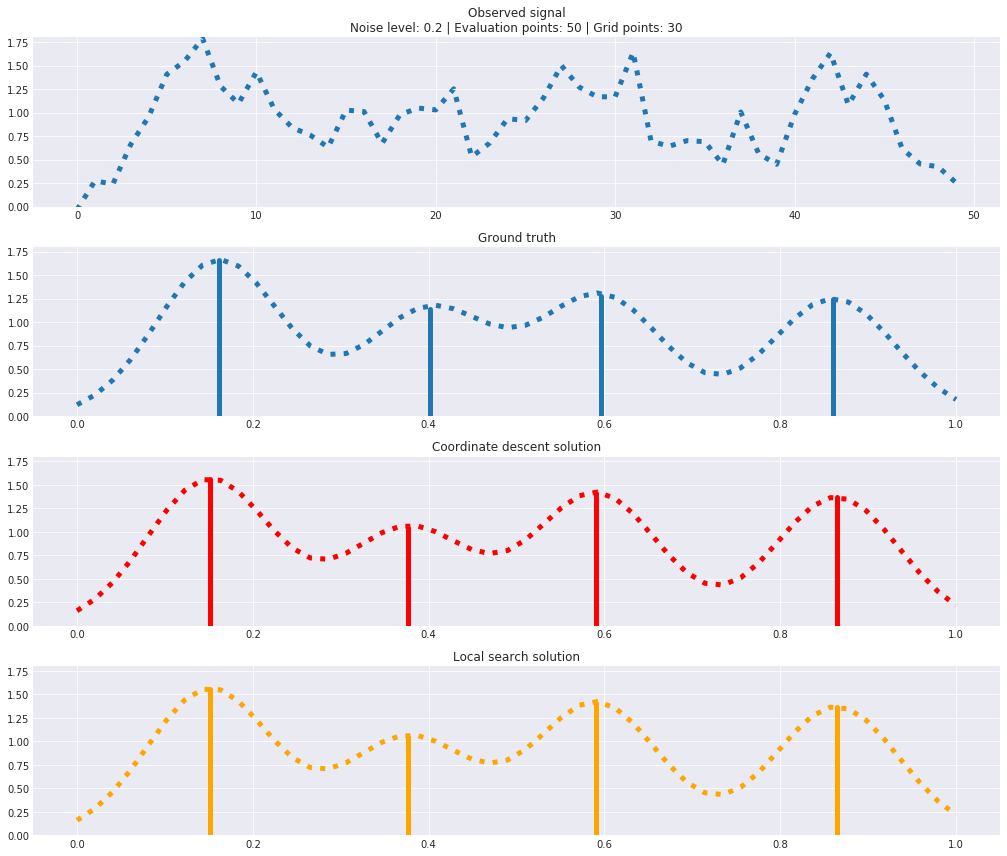

In [38]:
# Let's run it!
start = time()
res_cd = select_k(ADCG(coordinate_descent, 10))
time_cd = time() - start
start = time()
res_ls = select_k(ADCG(local_search, 10))
time_ls = time() - start
# True results
print("Ground truth results")
print("---------------------")
print("True loss:", l(true_weights, true_θs))
print("True θs:", true_θs)
print("True weights:", true_weights)
print("---------------------\n")
# Coordinate descent results
print("Coordinate descent results")
print("---------------------")
print("Coordinate descent loss: %.3f" % res_cd[0])
print("Coordinate descent θs:", res_cd[1])
print("Coordinate descent weights:", res_cd[2])
print("Coordinate descent timing: %.3fs" % time_cd)
print("---------------------\n")
# Joint optimization results
print("Joint optimization results")
print("---------------------")
print("Local search loss: %.3f" % res_ls[0])
print("Local search θs:", res_ls[1])
print("Local search weights:", res_ls[2])
print("Local search timing: %.3fs" % time_ls)
print("---------------------\n")
figure, axes = pylab.subplots(nrows=4, ncols=1, figsize=(14, 12))
for ax in axes[1:]:
    ax.set_ylim(bottom=0., top=1.8)

axes[0].set_ylim(bottom=-0.3, top=2.7)
axes[0].set_title("Observed signal\n"
                  f"Noise level: {noise_level} | "
                  f"Evaluation points: {len(evaluation_points)} | "
                  f"Grid points: {len(grid_points)}")
axes[0].set_ylim(bottom=0., top=1.8)
axes[0].plot(y)
axes[1].set_title("Ground truth")
axes[1].set_ylim(bottom=0., top=1.8)
axes[1].plot(evaluation_points, Ψ(true_weights, true_θs))
for i, θ in enumerate(true_θs):
    axes[1].axvline(x=θ, ymax=true_weights[i] / axes[1].get_ylim()[1],
                    linestyle="-")
axes[2].set_title("Coordinate descent solution")
axes[2].set_ylim(bottom=0., top=1.8)
axes[2].plot(evaluation_points, Ψ(res_cd[2], res_cd[1]), c="red")
for i, θ in enumerate(res_cd[1]):
    axes[2].axvline(x=θ, ymax=res_cd[2][i] / axes[2].get_ylim()[1],
                    linestyle="-", color="red")
axes[3].set_title("Local search solution")
axes[3].set_ylim(bottom=0., top=1.8)
axes[3].plot(evaluation_points, Ψ(res_ls[2], res_ls[1]), c="orange")
for i, θ in enumerate(res_ls[1]):
    axes[3].axvline(x=θ, ymax=res_ls[2][i] / axes[3].get_ylim()[1],
                    linestyle="-", color="orange")
pylab.tight_layout();

**Comment:**

* Same final loss for both methods.

* The ``coordinate descent`` variant is faster than the ``local search`` variant.

* Both are able to recover the correct amount of sources despite the noisy singal. However the weights intensity are similar yet different from the ground truth. For instance the first two sources' weights are less intense in both variants but the last two are more intense.

* Both method are able to handle this noise level (recall that $\sigma = 0.2$).

## Add more noise in previous setting

### Problem setting

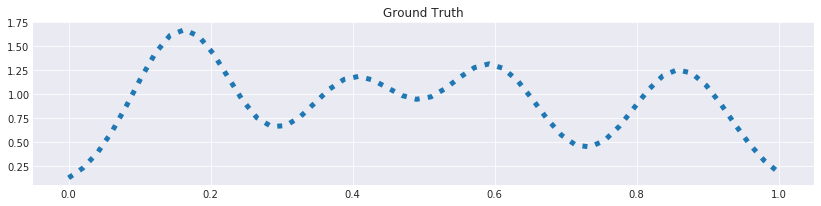

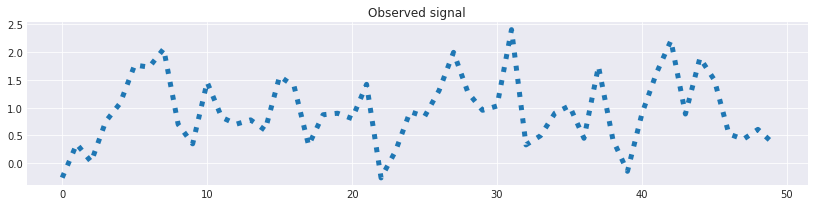

In [39]:
# Generate ground truth θs and weights ws
np.random.seed(69)
num_true_θs = np.random.randint(2, 5)
noise_level = 0.5
true_θs = np.random.rand(num_true_θs)
true_weights = np.random.rand(num_true_θs) + 1
y = (Ψ(true_weights, true_θs) 
     + noise_level * np.random.randn(len(evaluation_points)))
pylab.figure()
pylab.title("Ground Truth")
pylab.plot(evaluation_points, Ψ(true_weights, true_θs))
pylab.figure()
pylab.title("Observed signal")
pylab.plot(y);

In [40]:
# ADCG first step "linear minimization oracle"
# We will grid θ to approximately solve the problem
grid_points = np.linspace(0, 1, 30)
grid_psi = np.stack([ψ(θ) for θ in grid_points])

### Results

Ground truth results
---------------------
True loss: 16.302245990371713
True θs: [0.40157872 0.59582391 0.16174899 0.8603238 ]
True weights: [1.1430533  1.28132229 1.66428121 1.25002847]
---------------------

Coordinate descent results
---------------------
Coordinate descent loss: 12.575
Coordinate descent θs: [0.57254485 0.87819894 0.1310222  0.3368363  0.70039627]
Coordinate descent weights: [1.34594478 1.4663888  1.40136409 1.00131438 0.42463964]
Coordinate descent timing: 0.260s
---------------------

Joint optimization results
---------------------
Local search loss: 12.575
Local search θs: [0.5724522  0.87819973 0.13101988 0.33682378 0.70014102]
Local search weights: [1.34430387 1.46657851 1.40144092 1.00122395 0.42637786]
Local search timing: 0.969s
---------------------



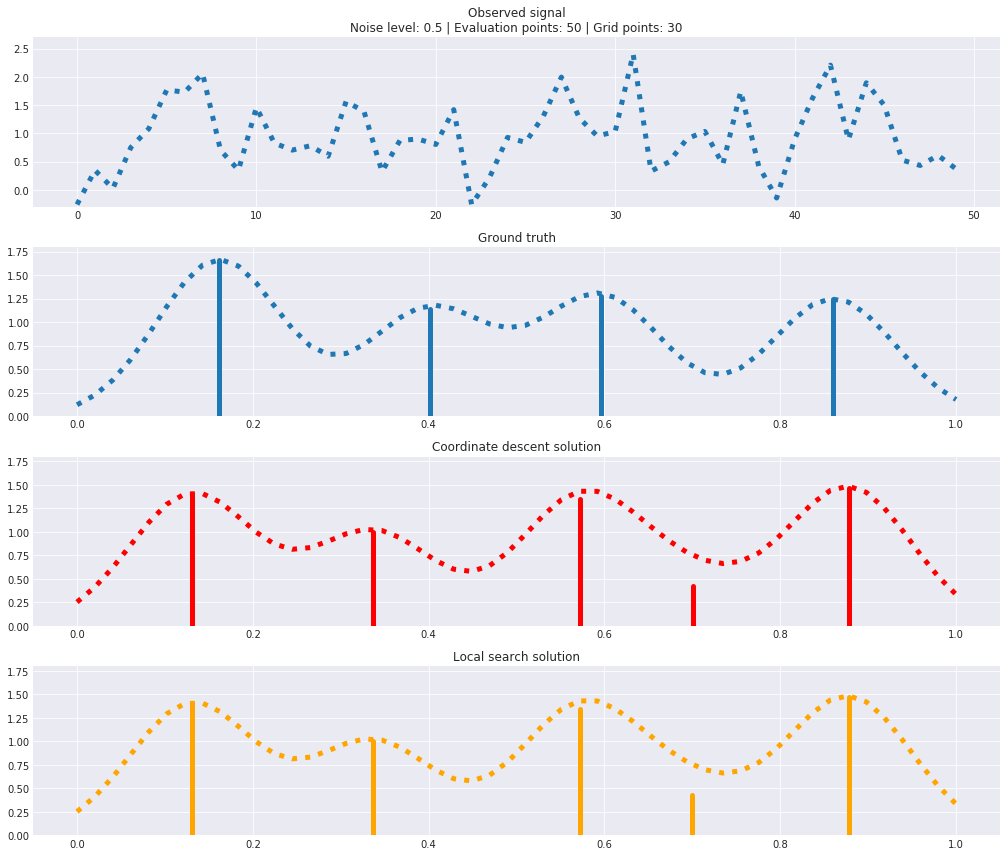

In [41]:
# Let's run it!
start = time()
res_cd = select_k(ADCG(coordinate_descent, 10))
time_cd = time() - start
start = time()
res_ls = select_k(ADCG(local_search, 10))
time_ls = time() - start
# True results
print("Ground truth results")
print("---------------------")
print("True loss:", l(true_weights, true_θs))
print("True θs:", true_θs)
print("True weights:", true_weights)
print("---------------------\n")
# Coordinate descent results
print("Coordinate descent results")
print("---------------------")
print("Coordinate descent loss: %.3f" % res_cd[0])
print("Coordinate descent θs:", res_cd[1])
print("Coordinate descent weights:", res_cd[2])
print("Coordinate descent timing: %.3fs" % time_cd)
print("---------------------\n")
# Joint optimization results
print("Joint optimization results")
print("---------------------")
print("Local search loss: %.3f" % res_ls[0])
print("Local search θs:", res_ls[1])
print("Local search weights:", res_ls[2])
print("Local search timing: %.3fs" % time_ls)
print("---------------------\n")
figure, axes = pylab.subplots(nrows=4, ncols=1, figsize=(14, 12))

for ax in axes[1:]:
    ax.set_ylim(bottom=0., top=1.8)

axes[0].set_ylim(bottom=-0.3, top=2.7)
axes[0].set_title("Observed signal\n"
                  f"Noise level: {noise_level} | "
                  f"Evaluation points: {len(evaluation_points)} | "
                  f"Grid points: {len(grid_points)}")
axes[0].plot(y)
axes[1].set_title("Ground truth")
axes[1].plot(evaluation_points, Ψ(true_weights, true_θs))
for i, θ in enumerate(true_θs):
    axes[1].axvline(x=θ, ymin=0, 
                    ymax=true_weights[i] / axes[1].get_ylim()[1],
                    linestyle="-")
axes[2].set_title("Coordinate descent solution")
axes[2].plot(evaluation_points, Ψ(res_cd[2], res_cd[1]), c="red")
for i, θ in enumerate(res_cd[1]):
    axes[2].axvline(x=θ, ymin=0, 
                    ymax=res_cd[2][i] / axes[2].get_ylim()[1],
                    linestyle="-", color="red")
axes[3].set_title("Local search solution")
axes[3].plot(evaluation_points, Ψ(res_ls[2], res_ls[1]), c="orange")
for i, θ in enumerate(res_ls[1]):
    axes[3].axvline(x=θ, ymin=0, 
                    ymax=res_ls[2][i] / axes[3].get_ylim()[1],
                    linestyle="-", color="orange")
    

pylab.tight_layout();

**Comment:**

* Here we see how the increased noise level induced an additional source of low intensity. However we see that sparsity is still well enforced.

### Problem setting

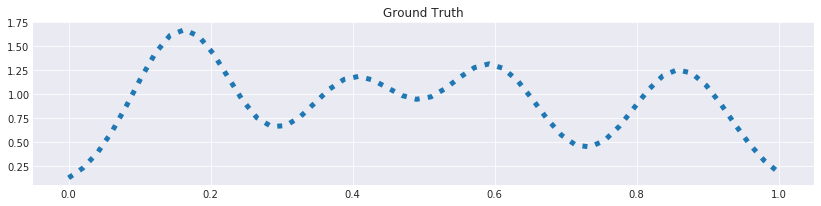

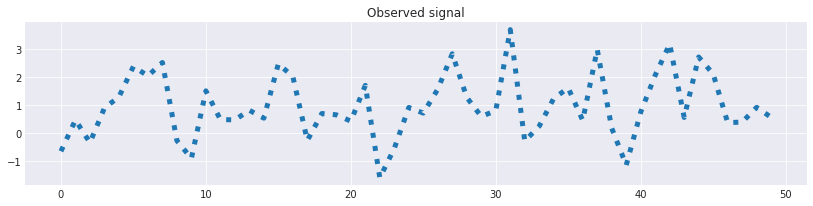

In [42]:
# Generate ground truth θs and weights ws
np.random.seed(69)
num_true_θs = np.random.randint(2, 5)
noise_level = 1.0
true_θs = np.random.rand(num_true_θs)
true_weights = np.random.rand(num_true_θs) + 1
y = (Ψ(true_weights, true_θs) 
     + noise_level * np.random.randn(len(evaluation_points)))
pylab.figure()
pylab.title("Ground Truth")
pylab.plot(evaluation_points, Ψ(true_weights, true_θs))
pylab.figure()
pylab.title("Observed signal")
pylab.plot(y);

In [43]:
# ADCG first step "linear minimization oracle"
# We will grid θ to approximately solve the problem
grid_points = np.linspace(0, 1, 30)
grid_psi = np.stack([ψ(θ) for θ in grid_points])

### Results

Ground truth results
---------------------
True loss: 65.20898396148685
True θs: [0.40157872 0.59582391 0.16174899 0.8603238 ]
True weights: [1.1430533  1.28132229 1.66428121 1.25002847]
---------------------

Coordinate descent results
---------------------
Coordinate descent loss: 52.806
Coordinate descent θs: [0.88615596 0.58088099 0.11119925 0.31715313 0.70887378]
Coordinate descent weights: [1.74089671 1.42910541 1.28551081 1.0362369  0.53434096]
Coordinate descent timing: 0.275s
---------------------

Joint optimization results
---------------------
Local search loss: 52.806
Local search θs: [0.88615635 0.5808348  0.11120055 0.31714413 0.70874798]
Local search weights: [1.74107235 1.42783089 1.28500146 1.03600459 0.53544623]
Local search timing: 0.827s
---------------------



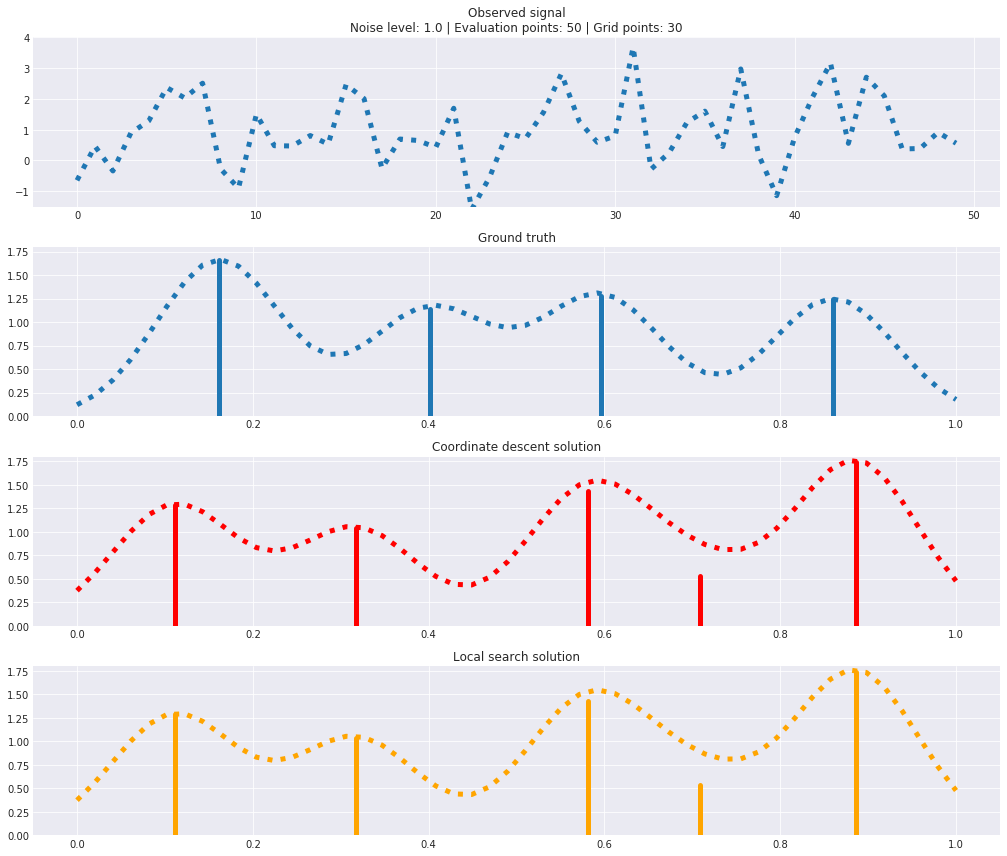

In [44]:
# Let's run it!
start = time()
res_cd = select_k(ADCG(coordinate_descent, 10))
time_cd = time() - start
start = time()
res_ls = select_k(ADCG(local_search, 10))
time_ls = time() - start
# True results
print("Ground truth results")
print("---------------------")
print("True loss:", l(true_weights, true_θs))
print("True θs:", true_θs)
print("True weights:", true_weights)
print("---------------------\n")
# Coordinate descent results
print("Coordinate descent results")
print("---------------------")
print("Coordinate descent loss: %.3f" % res_cd[0])
print("Coordinate descent θs:", res_cd[1])
print("Coordinate descent weights:", res_cd[2])
print("Coordinate descent timing: %.3fs" % time_cd)
print("---------------------\n")
# Joint optimization results
print("Joint optimization results")
print("---------------------")
print("Local search loss: %.3f" % res_ls[0])
print("Local search θs:", res_ls[1])
print("Local search weights:", res_ls[2])
print("Local search timing: %.3fs" % time_ls)
print("---------------------\n")
figure, axes = pylab.subplots(nrows=4, ncols=1, figsize=(14, 12))

for ax in axes[1:]:
    ax.set_ylim(bottom=0., top=1.8)

axes[0].set_ylim(bottom=-1.5, top=4.)
axes[0].set_title("Observed signal\n"
                  f"Noise level: {noise_level} | "
                  f"Evaluation points: {len(evaluation_points)} | "
                  f"Grid points: {len(grid_points)}")
axes[0].plot(y)
axes[1].set_title("Ground truth")
axes[1].plot(evaluation_points, Ψ(true_weights, true_θs))
for i, θ in enumerate(true_θs):
    axes[1].axvline(x=θ, ymin=0, 
                    ymax=true_weights[i] / axes[1].get_ylim()[1],
                    linestyle="-")
axes[2].set_title("Coordinate descent solution")
axes[2].plot(evaluation_points, Ψ(res_cd[2], res_cd[1]), c="red")
for i, θ in enumerate(res_cd[1]):
    axes[2].axvline(x=θ, ymin=0, 
                    ymax=res_cd[2][i] / axes[2].get_ylim()[1],
                    linestyle="-", color="red")
axes[3].set_title("Local search solution")
axes[3].plot(evaluation_points, Ψ(res_ls[2], res_ls[1]), c="orange")
for i, θ in enumerate(res_ls[1]):
    axes[3].axvline(x=θ, ymin=0, 
                    ymax=res_ls[2][i] / axes[3].get_ylim()[1],
                    linestyle="-", color="orange")
    

pylab.tight_layout();

**Comment:**

* Despite a dramatic increase in the noise level, we recover only one additional source. However we see that the source intensity no longer reflect the ground truth as highlighted by the high final loss.

#### TODO: Plot the loss / number of sources as a function of the noise level

## Change the number of evaluation points in previous setting

### Problem setting

We go back to the previous setting ($\sigma=0.2$) but change the evaluation points to 75 (50% increase from the original 50).

In [45]:
# Evaluation points
evaluation_points = np.linspace(0, 1, 75)

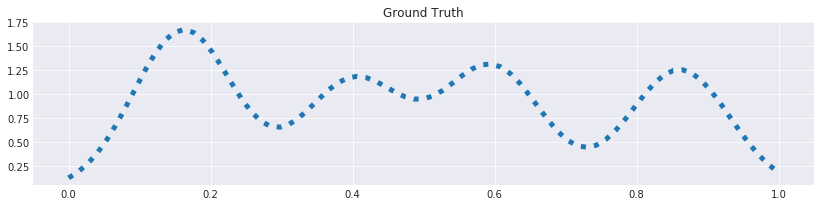

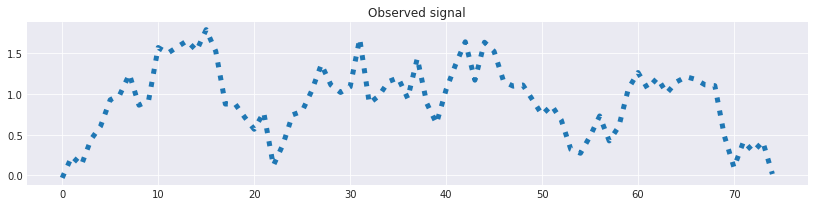

In [46]:
# Generate ground truth θs and weights ws
np.random.seed(69)
num_true_θs = np.random.randint(2, 5)
noise_level = 0.2
true_θs = np.random.rand(num_true_θs)
true_weights = np.random.rand(num_true_θs) + 1
y = (Ψ(true_weights, true_θs) 
     + noise_level * np.random.randn(len(evaluation_points)))
pylab.figure()
pylab.title("Ground Truth")
pylab.plot(evaluation_points, Ψ(true_weights, true_θs))
pylab.figure()
pylab.title("Observed signal")
pylab.plot(y);

In [47]:
# ADCG first step "linear minimization oracle"
# We will grid θ to approximately solve the problem
grid_points = np.linspace(0, 1, 30)
grid_psi = np.stack([ψ(θ) for θ in grid_points])

### Results

Ground truth results
---------------------
True loss: 3.465294285214292
True θs: [0.40157872 0.59582391 0.16174899 0.8603238 ]
True weights: [1.1430533  1.28132229 1.66428121 1.25002847]
---------------------

Coordinate descent results
---------------------
Coordinate descent loss: 3.223
Coordinate descent θs: [0.16277986 0.59908277 0.85622045 0.40915782]
Coordinate descent weights: [1.61749402 1.35828363 1.21504773 1.18100904]
Coordinate descent timing: 0.339s
---------------------

Joint optimization results
---------------------
Local search loss: 3.223
Local search θs: [0.16278013 0.85622051 0.59908572 0.40916069]
Local search weights: [1.61751341 1.21503238 1.35821679 1.1810786 ]
Local search timing: 1.082s
---------------------



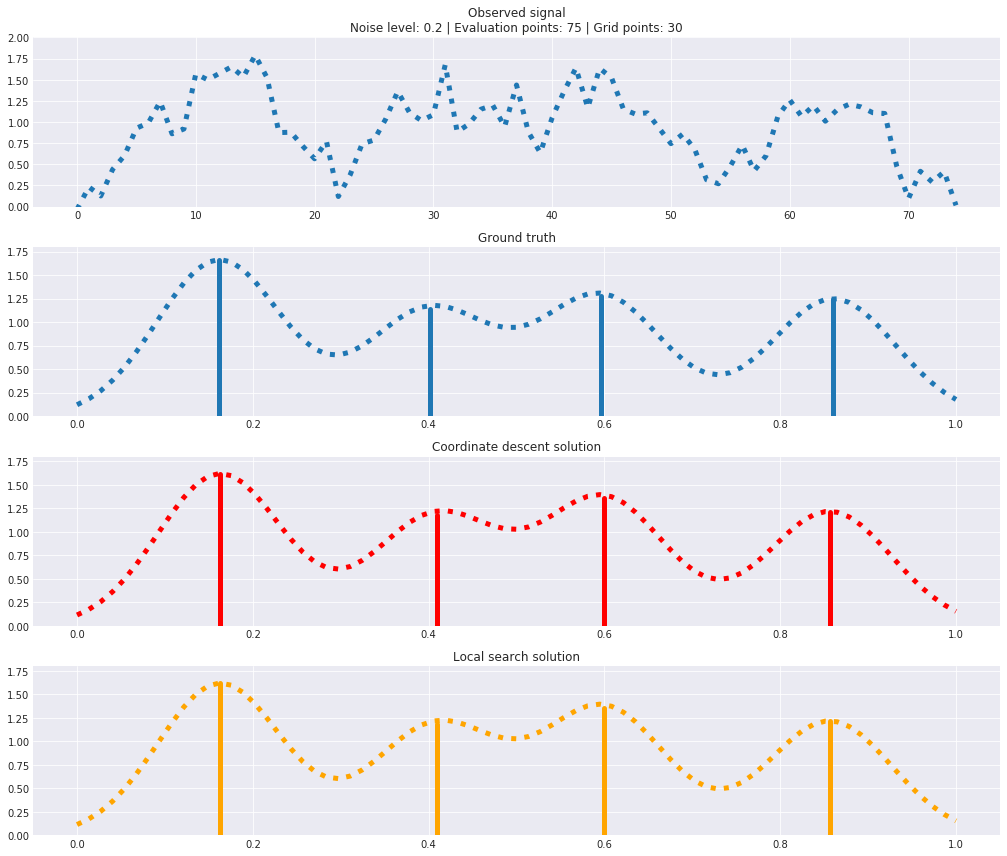

In [49]:
# Let's run it!
start = time()
res_cd = select_k(ADCG(coordinate_descent, 10))
time_cd = time() - start
start = time()
res_ls = select_k(ADCG(local_search, 10))
time_ls = time() - start
# True results
print("Ground truth results")
print("---------------------")
print("True loss:", l(true_weights, true_θs))
print("True θs:", true_θs)
print("True weights:", true_weights)
print("---------------------\n")
# Coordinate descent results
print("Coordinate descent results")
print("---------------------")
print("Coordinate descent loss: %.3f" % res_cd[0])
print("Coordinate descent θs:", res_cd[1])
print("Coordinate descent weights:", res_cd[2])
print("Coordinate descent timing: %.3fs" % time_cd)
print("---------------------\n")
# Joint optimization results
print("Joint optimization results")
print("---------------------")
print("Local search loss: %.3f" % res_ls[0])
print("Local search θs:", res_ls[1])
print("Local search weights:", res_ls[2])
print("Local search timing: %.3fs" % time_ls)
print("---------------------\n")
figure, axes = pylab.subplots(nrows=4, ncols=1, figsize=(14, 12))

for ax in axes[1:]:
    ax.set_ylim(bottom=0., top=1.8)

axes[0].set_ylim(bottom=0, top=2.)
axes[0].set_title("Observed signal\n"
                  f"Noise level: {noise_level} | "
                  f"Evaluation points: {len(evaluation_points)} | "
                  f"Grid points: {len(grid_points)}")
axes[0].plot(y)
axes[1].set_title("Ground truth")
axes[1].plot(evaluation_points, Ψ(true_weights, true_θs))
for i, θ in enumerate(true_θs):
    axes[1].axvline(x=θ, ymin=0, 
                    ymax=true_weights[i] / axes[1].get_ylim()[1],
                    linestyle="-")
axes[2].set_title("Coordinate descent solution")
axes[2].plot(evaluation_points, Ψ(res_cd[2], res_cd[1]), c="red")
for i, θ in enumerate(res_cd[1]):
    axes[2].axvline(x=θ, ymin=0, 
                    ymax=res_cd[2][i] / axes[2].get_ylim()[1],
                    linestyle="-", color="red")
axes[3].set_title("Local search solution")
axes[3].plot(evaluation_points, Ψ(res_ls[2], res_ls[1]), c="orange")
for i, θ in enumerate(res_ls[1]):
    axes[3].axvline(x=θ, ymin=0, 
                    ymax=res_ls[2][i] / axes[3].get_ylim()[1],
                    linestyle="-", color="orange")
    

pylab.tight_layout();

**Comment:**

We see that increasing the number of evaluation points resulted in a solution that is closer to the ground truth (both the sources position and the sources intensity).

### Problem setting

Now let us reduce the evaluation points down to the grid points (30) which comes down to a 40% decreased from the original number of evaluation points.

In [51]:
# Evaluation points
evaluation_points = np.linspace(0, 1, 30)

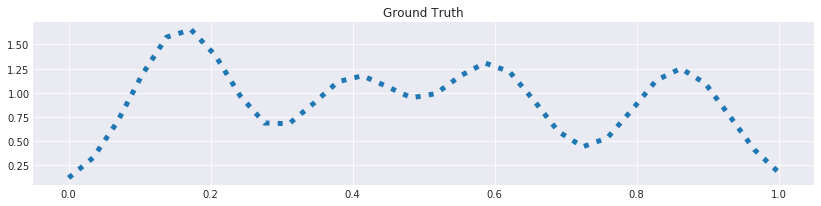

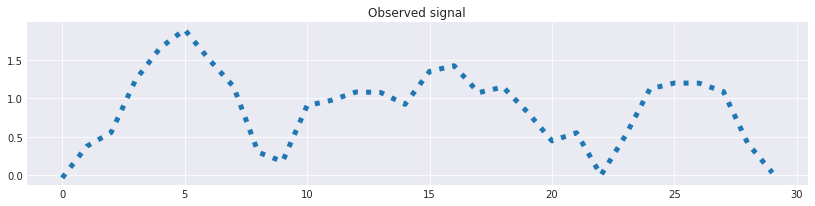

In [52]:
# Generate ground truth θs and weights ws
np.random.seed(69)
num_true_θs = np.random.randint(2, 5)
noise_level = 0.2
true_θs = np.random.rand(num_true_θs)
true_weights = np.random.rand(num_true_θs) + 1
y = (Ψ(true_weights, true_θs) 
     + noise_level * np.random.randn(len(evaluation_points)))
pylab.figure()
pylab.title("Ground Truth")
pylab.plot(evaluation_points, Ψ(true_weights, true_θs))
pylab.figure()
pylab.title("Observed signal")
pylab.plot(y);

In [53]:
# ADCG first step "linear minimization oracle"
# We will grid θ to approximately solve the problem
grid_points = np.linspace(0, 1, 30)
grid_psi = np.stack([ψ(θ) for θ in grid_points])

### Results

Ground truth results
---------------------
True loss: 1.4036537996119132
True θs: [0.40157872 0.59582391 0.16174899 0.8603238 ]
True weights: [1.1430533  1.28132229 1.66428121 1.25002847]
---------------------

Coordinate descent results
---------------------
Coordinate descent loss: 0.866
Coordinate descent θs: [0.16380551 0.58526204 0.87696363 0.41991063]
Coordinate descent weights: [1.78319572 1.24350681 1.23587378 1.00943742]
Coordinate descent timing: 0.891s
---------------------

Joint optimization results
---------------------
Local search loss: 0.866
Local search θs: [0.16380752 0.58529893 0.87696475 0.41995296]
Local search weights: [1.78327664 1.24291265 1.23582018 1.01005654]
Local search timing: 1.417s
---------------------



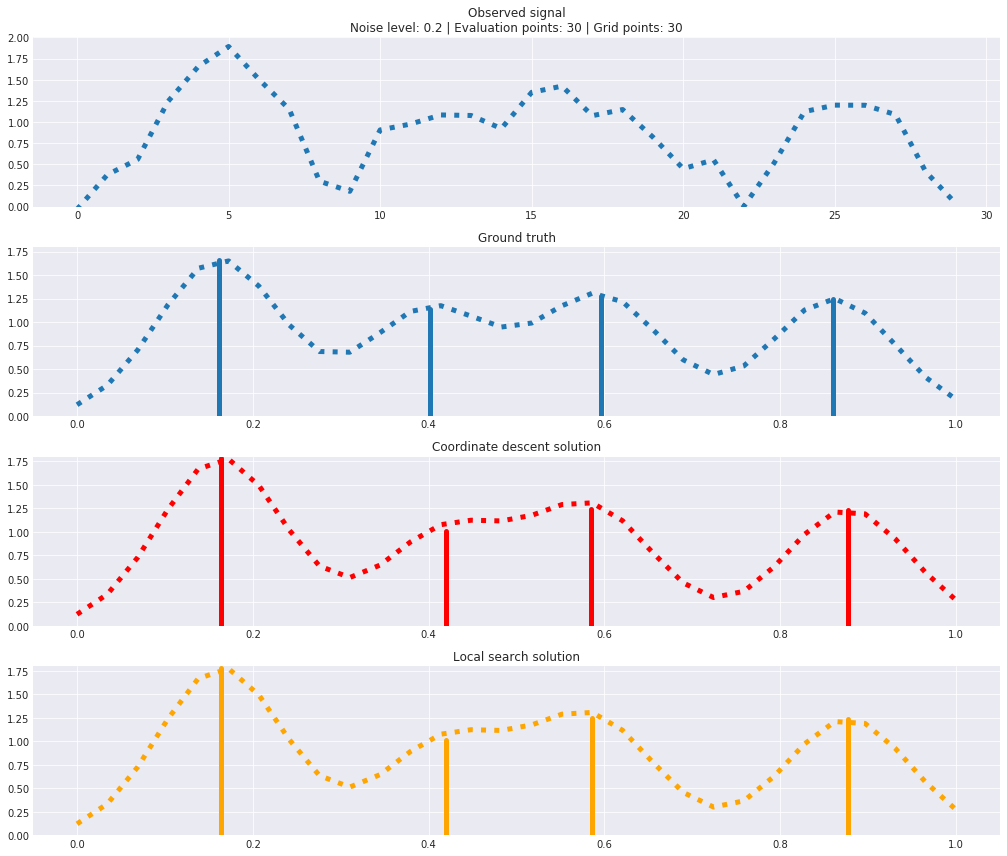

In [54]:
# Let's run it!
start = time()
res_cd = select_k(ADCG(coordinate_descent, 10))
time_cd = time() - start
start = time()
res_ls = select_k(ADCG(local_search, 10))
time_ls = time() - start
# True results
print("Ground truth results")
print("---------------------")
print("True loss:", l(true_weights, true_θs))
print("True θs:", true_θs)
print("True weights:", true_weights)
print("---------------------\n")
# Coordinate descent results
print("Coordinate descent results")
print("---------------------")
print("Coordinate descent loss: %.3f" % res_cd[0])
print("Coordinate descent θs:", res_cd[1])
print("Coordinate descent weights:", res_cd[2])
print("Coordinate descent timing: %.3fs" % time_cd)
print("---------------------\n")
# Joint optimization results
print("Joint optimization results")
print("---------------------")
print("Local search loss: %.3f" % res_ls[0])
print("Local search θs:", res_ls[1])
print("Local search weights:", res_ls[2])
print("Local search timing: %.3fs" % time_ls)
print("---------------------\n")
figure, axes = pylab.subplots(nrows=4, ncols=1, figsize=(14, 12))

for ax in axes[1:]:
    ax.set_ylim(bottom=0., top=1.8)

axes[0].set_ylim(bottom=0, top=2.)
axes[0].set_title("Observed signal\n"
                  f"Noise level: {noise_level} | "
                  f"Evaluation points: {len(evaluation_points)} | "
                  f"Grid points: {len(grid_points)}")
axes[0].plot(y)
axes[1].set_title("Ground truth")
axes[1].plot(evaluation_points, Ψ(true_weights, true_θs))
for i, θ in enumerate(true_θs):
    axes[1].axvline(x=θ, ymin=0, 
                    ymax=true_weights[i] / axes[1].get_ylim()[1],
                    linestyle="-")
axes[2].set_title("Coordinate descent solution")
axes[2].plot(evaluation_points, Ψ(res_cd[2], res_cd[1]), c="red")
for i, θ in enumerate(res_cd[1]):
    axes[2].axvline(x=θ, ymin=0, 
                    ymax=res_cd[2][i] / axes[2].get_ylim()[1],
                    linestyle="-", color="red")
axes[3].set_title("Local search solution")
axes[3].plot(evaluation_points, Ψ(res_ls[2], res_ls[1]), c="orange")
for i, θ in enumerate(res_ls[1]):
    axes[3].axvline(x=θ, ymin=0, 
                    ymax=res_ls[2][i] / axes[3].get_ylim()[1],
                    linestyle="-", color="orange")
    

pylab.tight_layout();

**Comment:**

We see that decreasing the number of evaluation points resulted in a solution that is less accurate with respect to the ground truth in the sense that the sources positions are no longer very precise and the intensity of the first two sources do not closely match. This is partly due to noise too but the evaluation points play in the role as the observed signal seems more "discontinuous".

## Change the size of the grid in previous setting

### Problem setting

Now let us increase the grid points to the former evaluation points (50) which comes down to a 67% increase from the original number of grid points.

In [55]:
# Evaluation points
evaluation_points = np.linspace(0, 1, 50)

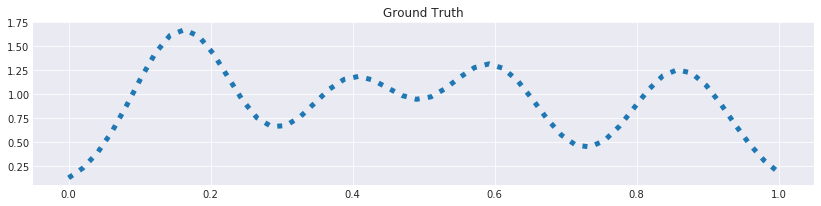

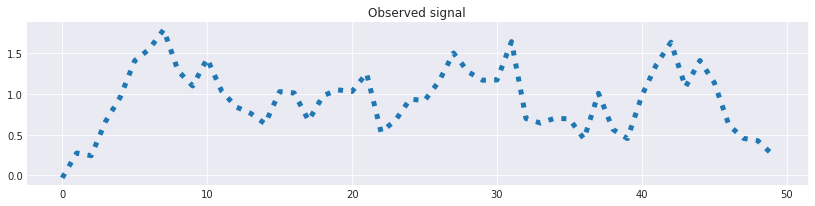

In [56]:
# Generate ground truth θs and weights ws
np.random.seed(69)
num_true_θs = np.random.randint(2, 5)
noise_level = 0.2
true_θs = np.random.rand(num_true_θs)
true_weights = np.random.rand(num_true_θs) + 1
y = (Ψ(true_weights, true_θs) 
     + noise_level * np.random.randn(len(evaluation_points)))
pylab.figure()
pylab.title("Ground Truth")
pylab.plot(evaluation_points, Ψ(true_weights, true_θs))
pylab.figure()
pylab.title("Observed signal")
pylab.plot(y);

In [57]:
# ADCG first step "linear minimization oracle"
# We will grid θ to approximately solve the problem
grid_points = np.linspace(0, 1, 50)
grid_psi = np.stack([ψ(θ) for θ in grid_points])

### Results

Ground truth results
---------------------
True loss: 2.608359358459474
True θs: [0.40157872 0.59582391 0.16174899 0.8603238 ]
True weights: [1.1430533  1.28132229 1.66428121 1.25002847]
---------------------

Coordinate descent results
---------------------
Coordinate descent loss: 2.074
Coordinate descent θs: [0.15096278 0.59086823 0.8643097  0.37707442]
Coordinate descent weights: [1.55973103 1.41075611 1.36874588 1.04334665]
Coordinate descent timing: 1.239s
---------------------

Joint optimization results
---------------------
Local search loss: 2.074
Local search θs: [0.15096298 0.59086993 0.86431003 0.37707769]
Local search weights: [1.5597653  1.41071558 1.36880723 1.04339601]
Local search timing: 1.618s
---------------------



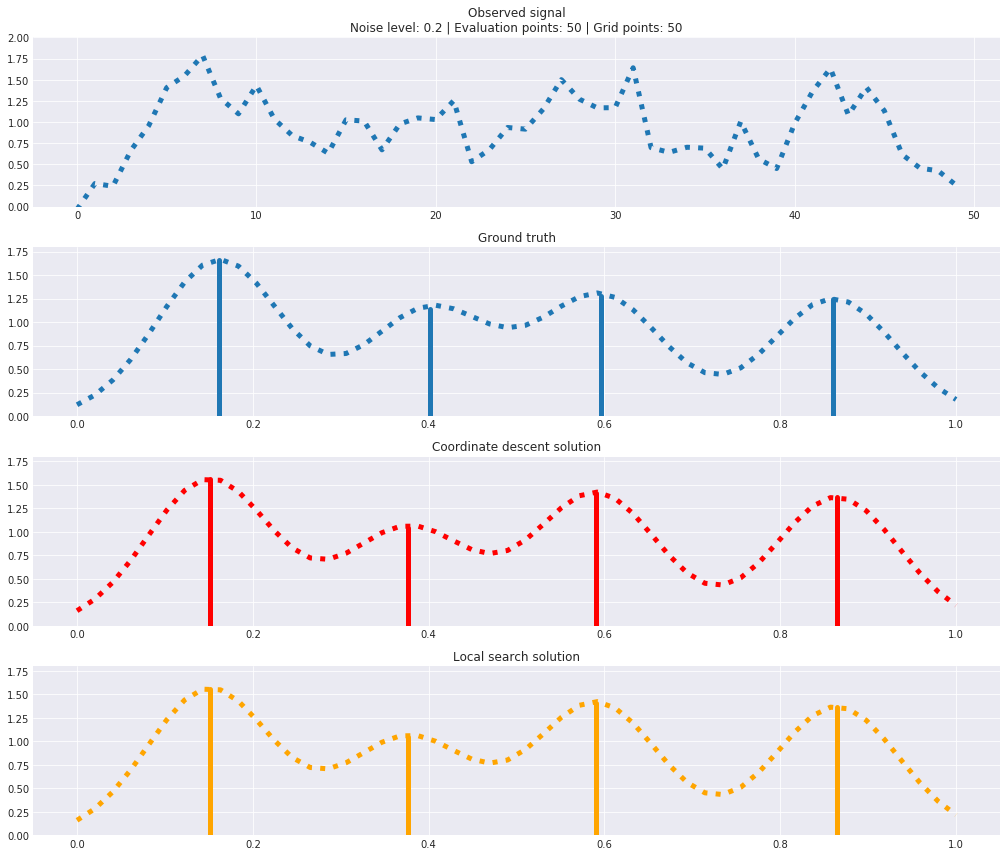

In [58]:
# Let's run it!
start = time()
res_cd = select_k(ADCG(coordinate_descent, 10))
time_cd = time() - start
start = time()
res_ls = select_k(ADCG(local_search, 10))
time_ls = time() - start
# True results
print("Ground truth results")
print("---------------------")
print("True loss:", l(true_weights, true_θs))
print("True θs:", true_θs)
print("True weights:", true_weights)
print("---------------------\n")
# Coordinate descent results
print("Coordinate descent results")
print("---------------------")
print("Coordinate descent loss: %.3f" % res_cd[0])
print("Coordinate descent θs:", res_cd[1])
print("Coordinate descent weights:", res_cd[2])
print("Coordinate descent timing: %.3fs" % time_cd)
print("---------------------\n")
# Joint optimization results
print("Joint optimization results")
print("---------------------")
print("Local search loss: %.3f" % res_ls[0])
print("Local search θs:", res_ls[1])
print("Local search weights:", res_ls[2])
print("Local search timing: %.3fs" % time_ls)
print("---------------------\n")
figure, axes = pylab.subplots(nrows=4, ncols=1, figsize=(14, 12))

for ax in axes[1:]:
    ax.set_ylim(bottom=0., top=1.8)

axes[0].set_ylim(bottom=0, top=2.)
axes[0].set_title("Observed signal\n"
                  f"Noise level: {noise_level} | "
                  f"Evaluation points: {len(evaluation_points)} | "
                  f"Grid points: {len(grid_points)}")
axes[0].plot(y)
axes[1].set_title("Ground truth")
axes[1].plot(evaluation_points, Ψ(true_weights, true_θs))
for i, θ in enumerate(true_θs):
    axes[1].axvline(x=θ, ymin=0, 
                    ymax=true_weights[i] / axes[1].get_ylim()[1],
                    linestyle="-")
axes[2].set_title("Coordinate descent solution")
axes[2].plot(evaluation_points, Ψ(res_cd[2], res_cd[1]), c="red")
for i, θ in enumerate(res_cd[1]):
    axes[2].axvline(x=θ, ymin=0, 
                    ymax=res_cd[2][i] / axes[2].get_ylim()[1],
                    linestyle="-", color="red")
axes[3].set_title("Local search solution")
axes[3].plot(evaluation_points, Ψ(res_ls[2], res_ls[1]), c="orange")
for i, θ in enumerate(res_ls[1]):
    axes[3].axvline(x=θ, ymin=0, 
                    ymax=res_ls[2][i] / axes[3].get_ylim()[1],
                    linestyle="-", color="orange")
    

pylab.tight_layout();

**Comment:**



### Problem setting

Now let us decrease the grid points to 20 grid points (20) which comes down to a 50% decrease from the original number of grid points.

In [59]:
# Evaluation points
evaluation_points = np.linspace(0, 1, 50)

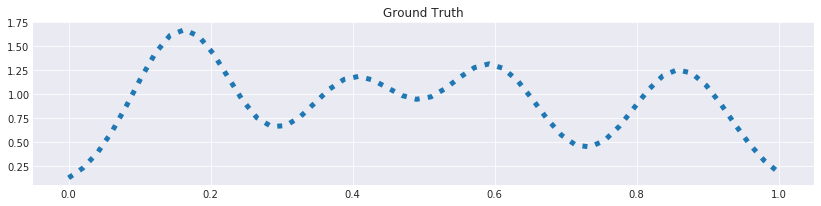

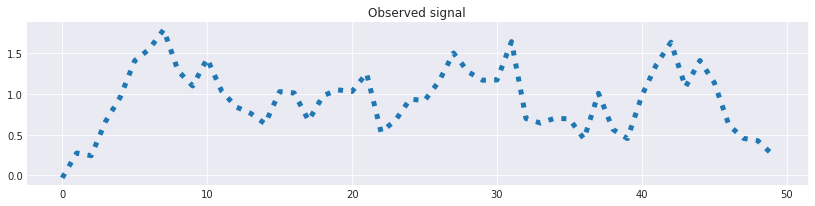

In [60]:
# Generate ground truth θs and weights ws
np.random.seed(69)
num_true_θs = np.random.randint(2, 5)
noise_level = 0.2
true_θs = np.random.rand(num_true_θs)
true_weights = np.random.rand(num_true_θs) + 1
y = (Ψ(true_weights, true_θs) 
     + noise_level * np.random.randn(len(evaluation_points)))
pylab.figure()
pylab.title("Ground Truth")
pylab.plot(evaluation_points, Ψ(true_weights, true_θs))
pylab.figure()
pylab.title("Observed signal")
pylab.plot(y);

In [61]:
# ADCG first step "linear minimization oracle"
# We will grid θ to approximately solve the problem
grid_points = np.linspace(0, 1, 20)
grid_psi = np.stack([ψ(θ) for θ in grid_points])

### Results

Ground truth results
---------------------
True loss: 2.608359358459474
True θs: [0.40157872 0.59582391 0.16174899 0.8603238 ]
True weights: [1.1430533  1.28132229 1.66428121 1.25002847]
---------------------

Coordinate descent results
---------------------
Coordinate descent loss: 2.074
Coordinate descent θs: [0.15096293 0.59086805 0.86430972 0.37707484]
Coordinate descent weights: [1.55973255 1.41075272 1.36874474 1.04334682]
Coordinate descent timing: 1.250s
---------------------

Joint optimization results
---------------------
Local search loss: 2.074
Local search θs: [0.1509646  0.59087205 0.86430872 0.37707879]
Local search weights: [1.55973527 1.41069109 1.36872543 1.04338112]
Local search timing: 1.567s
---------------------



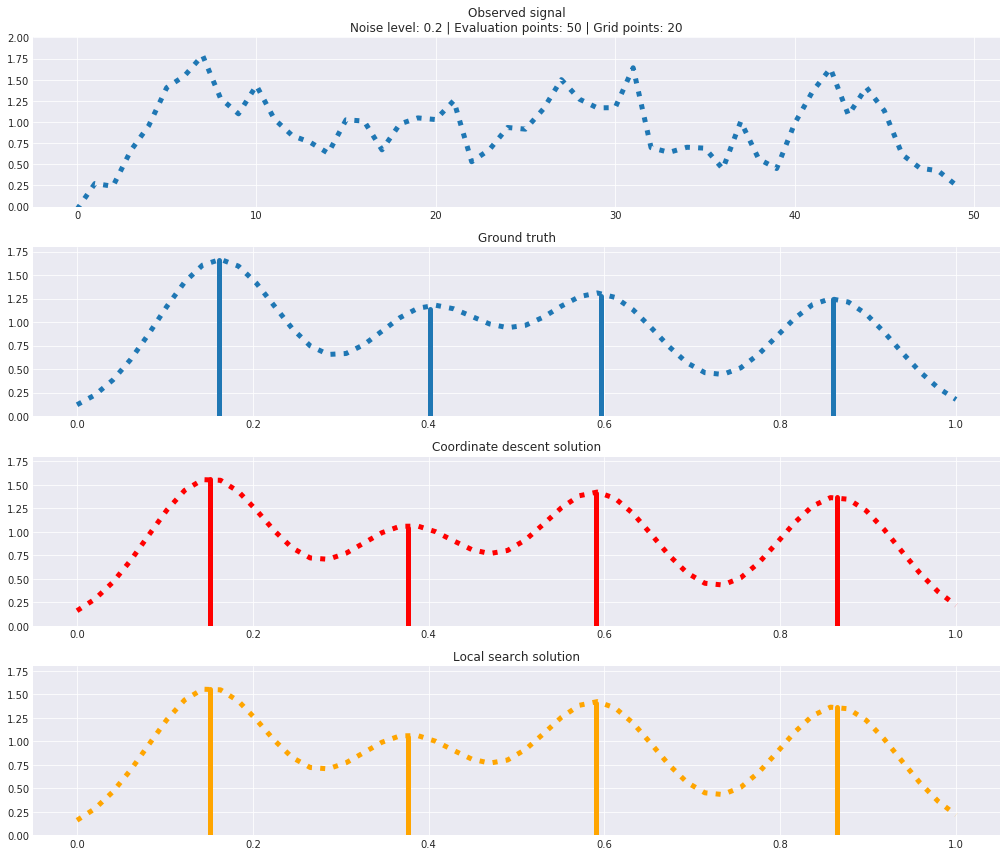

In [62]:
# Let's run it!
start = time()
res_cd = select_k(ADCG(coordinate_descent, 10))
time_cd = time() - start
start = time()
res_ls = select_k(ADCG(local_search, 10))
time_ls = time() - start
# True results
print("Ground truth results")
print("---------------------")
print("True loss:", l(true_weights, true_θs))
print("True θs:", true_θs)
print("True weights:", true_weights)
print("---------------------\n")
# Coordinate descent results
print("Coordinate descent results")
print("---------------------")
print("Coordinate descent loss: %.3f" % res_cd[0])
print("Coordinate descent θs:", res_cd[1])
print("Coordinate descent weights:", res_cd[2])
print("Coordinate descent timing: %.3fs" % time_cd)
print("---------------------\n")
# Joint optimization results
print("Joint optimization results")
print("---------------------")
print("Local search loss: %.3f" % res_ls[0])
print("Local search θs:", res_ls[1])
print("Local search weights:", res_ls[2])
print("Local search timing: %.3fs" % time_ls)
print("---------------------\n")
figure, axes = pylab.subplots(nrows=4, ncols=1, figsize=(14, 12))

for ax in axes[1:]:
    ax.set_ylim(bottom=0., top=1.8)

axes[0].set_ylim(bottom=0, top=2.)
axes[0].set_title("Observed signal\n"
                  f"Noise level: {noise_level} | "
                  f"Evaluation points: {len(evaluation_points)} | "
                  f"Grid points: {len(grid_points)}")
axes[0].plot(y)
axes[1].set_title("Ground truth")
axes[1].plot(evaluation_points, Ψ(true_weights, true_θs))
for i, θ in enumerate(true_θs):
    axes[1].axvline(x=θ, ymin=0, 
                    ymax=true_weights[i] / axes[1].get_ylim()[1],
                    linestyle="-")
axes[2].set_title("Coordinate descent solution")
axes[2].plot(evaluation_points, Ψ(res_cd[2], res_cd[1]), c="red")
for i, θ in enumerate(res_cd[1]):
    axes[2].axvline(x=θ, ymin=0, 
                    ymax=res_cd[2][i] / axes[2].get_ylim()[1],
                    linestyle="-", color="red")
axes[3].set_title("Local search solution")
axes[3].plot(evaluation_points, Ψ(res_ls[2], res_ls[1]), c="orange")
for i, θ in enumerate(res_ls[1]):
    axes[3].axvline(x=θ, ymin=0, 
                    ymax=res_ls[2][i] / axes[3].get_ylim()[1],
                    linestyle="-", color="orange")
    

pylab.tight_layout();

**Comment:**



## Make the bumps closer together / Add more bumps

### Problem setting

Now let us make some bumps closer and observe the effect on the reconstruction.

In [63]:
# Evaluation points
evaluation_points = np.linspace(0, 1, 50)

There are 4 sources


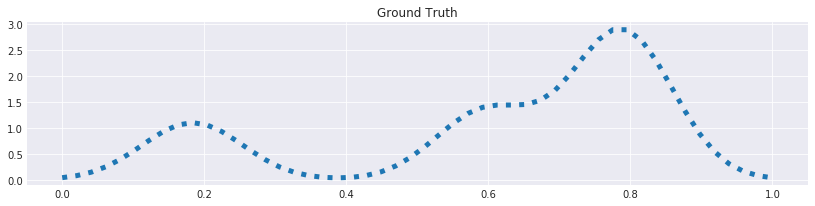

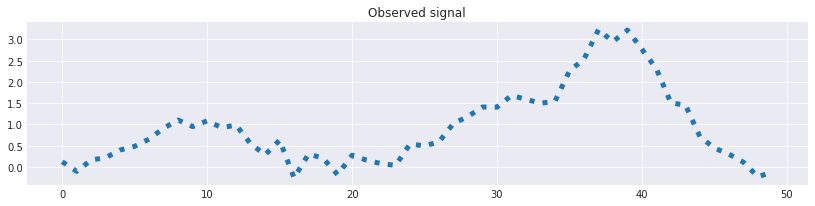

In [66]:
# Generate ground truth θs and weights ws
np.random.seed(42)
num_true_θs = np.random.randint(2, 5)
noise_level = 0.2
true_θs = np.random.rand(num_true_θs)
true_weights = np.random.rand(num_true_θs) + 1
y = (Ψ(true_weights, true_θs) 
     + noise_level * np.random.randn(len(evaluation_points)))
print(f"There are {num_true_θs} sources")
pylab.figure()
pylab.title("Ground Truth")
pylab.plot(evaluation_points, Ψ(true_weights, true_θs))
pylab.figure()
pylab.title("Observed signal")
pylab.plot(y);

In [67]:
# ADCG first step "linear minimization oracle"
# We will grid θ to approximately solve the problem
grid_points = np.linspace(0, 1, 30)
grid_psi = np.stack([ψ(θ) for θ in grid_points])

### Results

Ground truth results
---------------------
True loss: 1.6952124788742284
True θs: [0.79654299 0.18343479 0.779691   0.59685016]
True weights: [1.44583275 1.09997492 1.45924889 1.33370861]
---------------------

Coordinate descent results
---------------------
Coordinate descent loss: 1.335
Coordinate descent θs: [0.7837126  0.18989884 0.60084093]
Coordinate descent weights: [3.04963765 1.08902461 1.26401562]
Coordinate descent timing: 0.152s
---------------------

Joint optimization results
---------------------
Local search loss: 1.335
Local search θs: [0.78371425 0.18989853 0.60084476]
Local search weights: [3.04955833 1.08902132 1.26410852]
Local search timing: 1.026s
---------------------



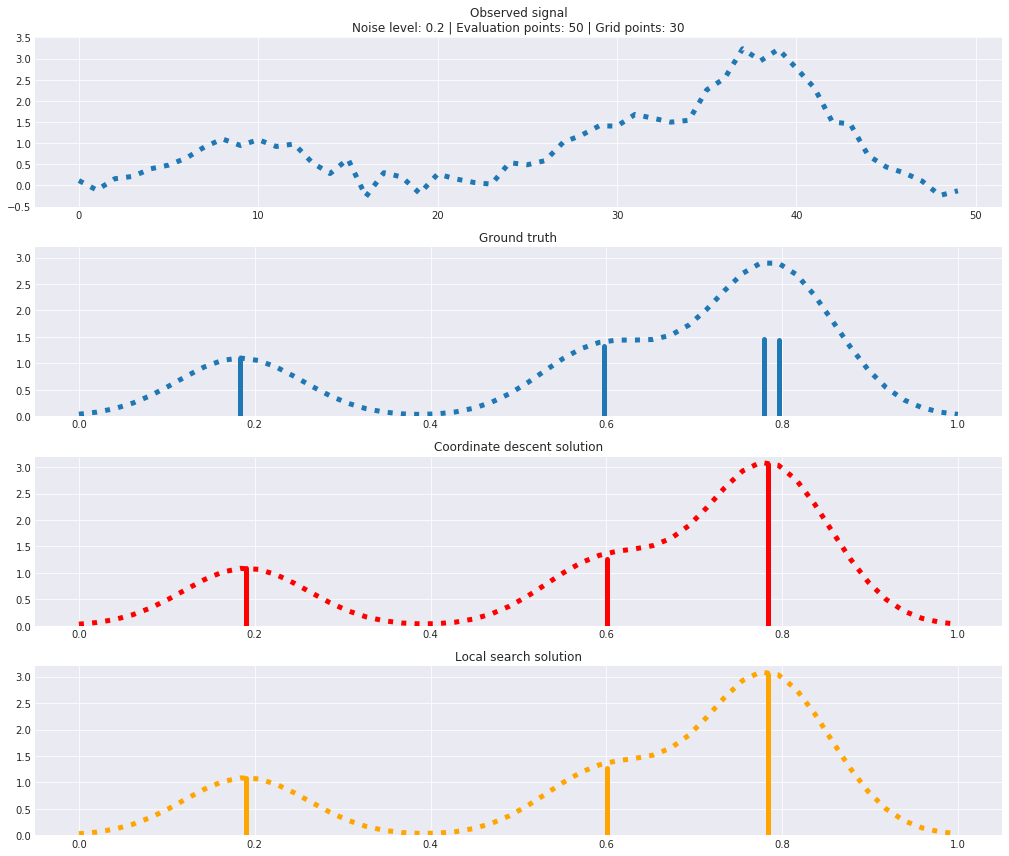

In [71]:
# Let's run it!
start = time()
res_cd = select_k(ADCG(coordinate_descent, 10))
time_cd = time() - start
start = time()
res_ls = select_k(ADCG(local_search, 10))
time_ls = time() - start
# True results
print("Ground truth results")
print("---------------------")
print("True loss:", l(true_weights, true_θs))
print("True θs:", true_θs)
print("True weights:", true_weights)
print("---------------------\n")
# Coordinate descent results
print("Coordinate descent results")
print("---------------------")
print("Coordinate descent loss: %.3f" % res_cd[0])
print("Coordinate descent θs:", res_cd[1])
print("Coordinate descent weights:", res_cd[2])
print("Coordinate descent timing: %.3fs" % time_cd)
print("---------------------\n")
# Joint optimization results
print("Joint optimization results")
print("---------------------")
print("Local search loss: %.3f" % res_ls[0])
print("Local search θs:", res_ls[1])
print("Local search weights:", res_ls[2])
print("Local search timing: %.3fs" % time_ls)
print("---------------------\n")
figure, axes = pylab.subplots(nrows=4, ncols=1, figsize=(14, 12))

for ax in axes[1:]:
    ax.set_ylim(bottom=0., top=3.2)

axes[0].set_ylim(bottom=-0.5, top=3.5)
axes[0].set_title("Observed signal\n"
                  f"Noise level: {noise_level} | "
                  f"Evaluation points: {len(evaluation_points)} | "
                  f"Grid points: {len(grid_points)}")
axes[0].plot(y)
axes[1].set_title("Ground truth")
axes[1].plot(evaluation_points, Ψ(true_weights, true_θs))
for i, θ in enumerate(true_θs):
    axes[1].axvline(x=θ, ymin=0, 
                    ymax=true_weights[i] / axes[1].get_ylim()[1],
                    linestyle="-")
axes[2].set_title("Coordinate descent solution")
axes[2].plot(evaluation_points, Ψ(res_cd[2], res_cd[1]), c="red")
for i, θ in enumerate(res_cd[1]):
    axes[2].axvline(x=θ, ymin=0, 
                    ymax=res_cd[2][i] / axes[2].get_ylim()[1],
                    linestyle="-", color="red")
axes[3].set_title("Local search solution")
axes[3].plot(evaluation_points, Ψ(res_ls[2], res_ls[1]), c="orange")
for i, θ in enumerate(res_ls[1]):
    axes[3].axvline(x=θ, ymin=0, 
                    ymax=res_ls[2][i] / axes[3].get_ylim()[1],
                    linestyle="-", color="orange")
    

pylab.tight_layout();

**Comment:**

What is interesting is that the reconstruction effectively replaced the two close sources of approximately the same intensity by a single source of doubled intensity which seems fair.

### Problem setting

Now let us make some bumps closer and observe the effect on the reconstruction.

In [63]:
# Evaluation points
evaluation_points = np.linspace(0, 1, 50)

There are 8 sources


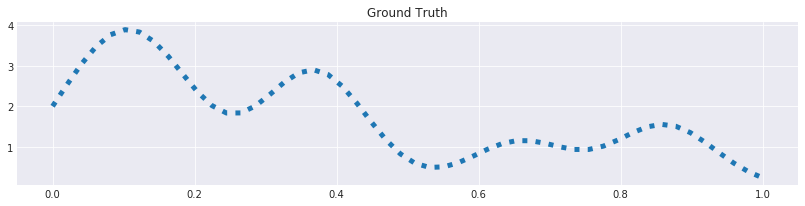

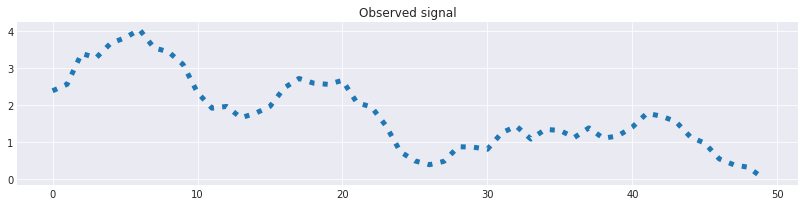

In [75]:
# Generate ground truth θs and weights ws
np.random.seed(70)
num_true_θs = np.random.randint(2, 10)
noise_level = 0.2
true_θs = np.random.rand(num_true_θs)
true_weights = np.random.rand(num_true_θs) + 1
y = (Ψ(true_weights, true_θs) 
     + noise_level * np.random.randn(len(evaluation_points)))
print(f"There are {num_true_θs} sources")
pylab.figure()
pylab.title("Ground Truth")
pylab.plot(evaluation_points, Ψ(true_weights, true_θs))
pylab.figure()
pylab.title("Observed signal")
pylab.plot(y);

In [76]:
# ADCG first step "linear minimization oracle"
# We will grid θ to approximately solve the problem
grid_points = np.linspace(0, 1, 30)
grid_psi = np.stack([ψ(θ) for θ in grid_points])

### Results

Ground truth results
---------------------
True loss: 2.176177983785328
True θs: [0.65765291 0.08306402 0.12552382 0.17057333 0.86161931 0.03239027
 0.34160295 0.3887434 ]
True weights: [1.12703223 1.21980663 1.36254689 1.13225911 1.53149861 1.15642215
 1.370899   1.66167755]
---------------------

Coordinate descent results
---------------------
Coordinate descent loss: 1.125
Coordinate descent θs: [0.0521697  0.37804921 0.84859221 0.66103433 0.16163477]
Coordinate descent weights: [2.64696398 2.79385902 1.56157152 1.27367976 2.54646446]
Coordinate descent timing: 3.029s
---------------------

Joint optimization results
---------------------
Local search loss: 1.082
Local search θs: [0.37662438 0.15060979 0.66065897 0.84847872 0.03592775]
Local search weights: [2.82342799 2.98998122 1.27443807 1.56304837 2.26814211]
Local search timing: 5.394s
---------------------



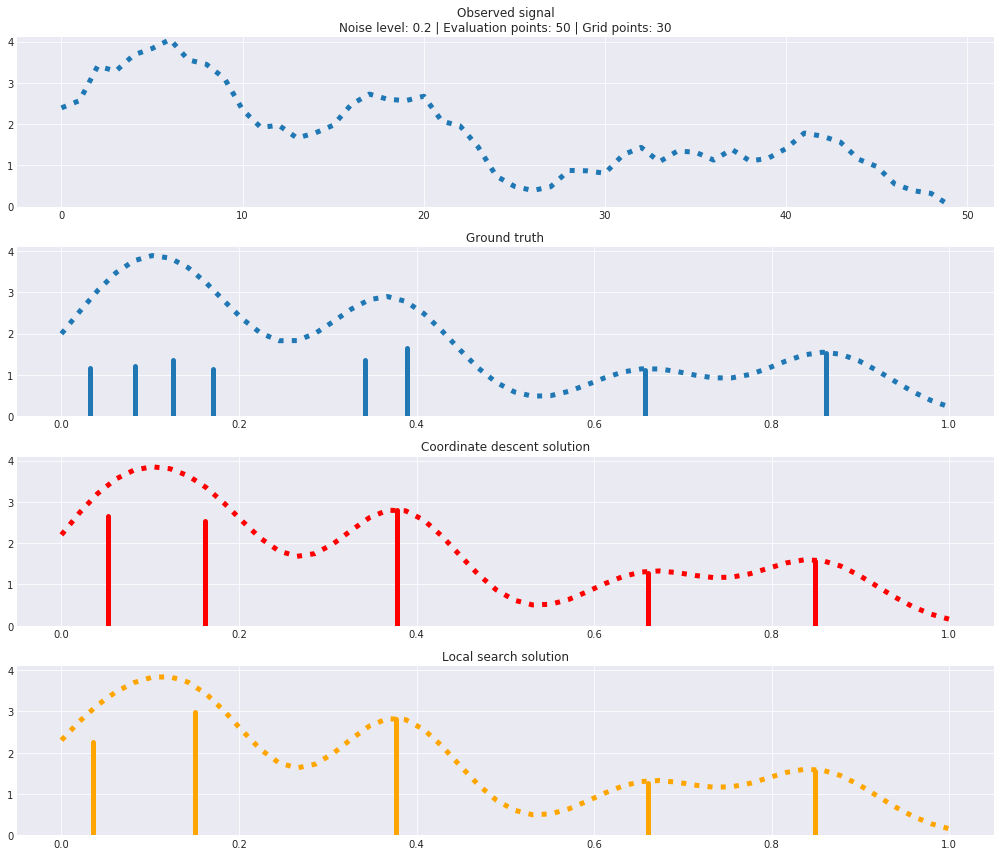

In [79]:
# Let's run it!
start = time()
res_cd = select_k(ADCG(coordinate_descent, 10))
time_cd = time() - start
start = time()
res_ls = select_k(ADCG(local_search, 10))
time_ls = time() - start
# True results
print("Ground truth results")
print("---------------------")
print("True loss:", l(true_weights, true_θs))
print("True θs:", true_θs)
print("True weights:", true_weights)
print("---------------------\n")
# Coordinate descent results
print("Coordinate descent results")
print("---------------------")
print("Coordinate descent loss: %.3f" % res_cd[0])
print("Coordinate descent θs:", res_cd[1])
print("Coordinate descent weights:", res_cd[2])
print("Coordinate descent timing: %.3fs" % time_cd)
print("---------------------\n")
# Joint optimization results
print("Joint optimization results")
print("---------------------")
print("Local search loss: %.3f" % res_ls[0])
print("Local search θs:", res_ls[1])
print("Local search weights:", res_ls[2])
print("Local search timing: %.3fs" % time_ls)
print("---------------------\n")
figure, axes = pylab.subplots(nrows=4, ncols=1, figsize=(14, 12))

for ax in axes[1:]:
    ax.set_ylim(bottom=0., top=4.1)

axes[0].set_ylim(bottom=0., top=4.1)
axes[0].set_title("Observed signal\n"
                  f"Noise level: {noise_level} | "
                  f"Evaluation points: {len(evaluation_points)} | "
                  f"Grid points: {len(grid_points)}")
axes[0].plot(y)
axes[1].set_title("Ground truth")
axes[1].plot(evaluation_points, Ψ(true_weights, true_θs))
for i, θ in enumerate(true_θs):
    axes[1].axvline(x=θ, ymin=0, 
                    ymax=true_weights[i] / axes[1].get_ylim()[1],
                    linestyle="-")
axes[2].set_title("Coordinate descent solution")
axes[2].plot(evaluation_points, Ψ(res_cd[2], res_cd[1]), c="red")
for i, θ in enumerate(res_cd[1]):
    axes[2].axvline(x=θ, ymin=0, 
                    ymax=res_cd[2][i] / axes[2].get_ylim()[1],
                    linestyle="-", color="red")
axes[3].set_title("Local search solution")
axes[3].plot(evaluation_points, Ψ(res_ls[2], res_ls[1]), c="orange")
for i, θ in enumerate(res_ls[1]):
    axes[3].axvline(x=θ, ymin=0, 
                    ymax=res_ls[2][i] / axes[3].get_ylim()[1],
                    linestyle="-", color="orange")
    

pylab.tight_layout();

**Comment:**

Longer search time. The merged sources have roughly a doubled intensity from the original source.

Still recover 2 sources in the first bump (composed of 4 sources).